# Ejercicios

In [4]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mtp
import matplotlib.patches as mpatches

SIZE_FACTOR = 2

mtp.rcParams['figure.figsize'] = (10, 4)
mtp.rcParams['figure.dpi'] = 300

## 1) Grafique la señal de voz del archivo hh15.wav, ubicando en ella porciones de señales que se o correspondan con fonemas sonoros y sordos. Segmentar y etiquetar en forma aproximada cada uno del los fonemas presentes en la señal.

Fonemas a mano por Gastón en `Letter.LETTERS_POSITION`

Rate: 16000 | Muestras: 54656 | Duracion 3.416s | Duracion/Muestras = 6.25e-05


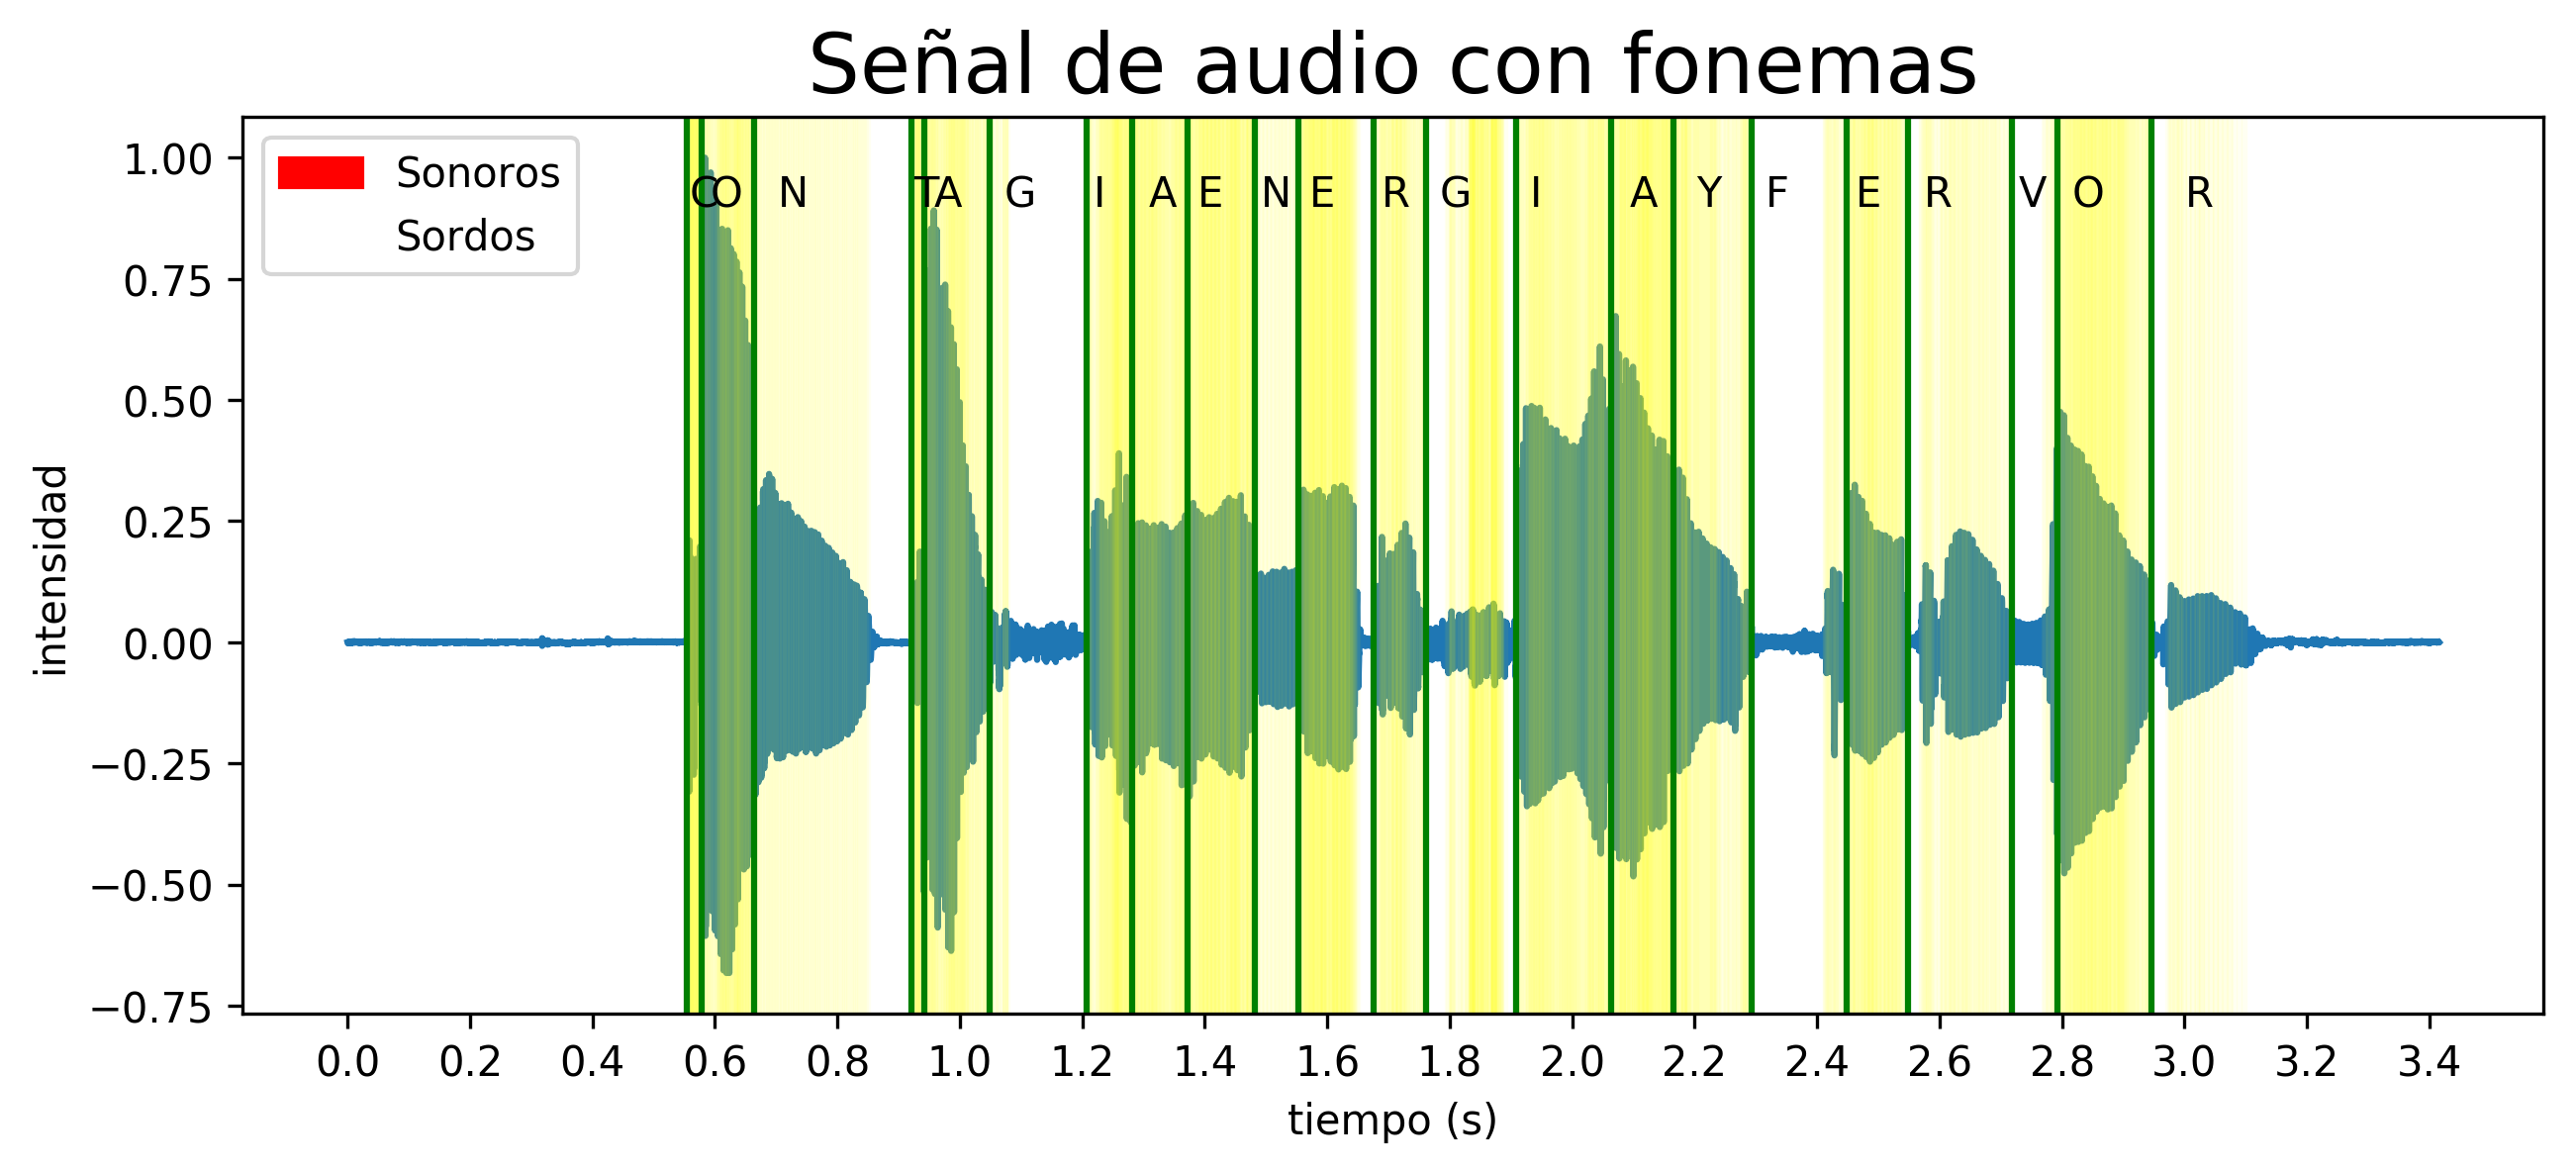

In [148]:
from scipy.io import wavfile
from tp.vocal import Letter

(FS, Y) = wavfile.read("res/hh15.WAV")

# Duracion
L = len(Y)/FS
print("Rate: {} | Muestras: {} | Duracion {}s | Duracion/Muestras = {}".format(FS, len(Y), L, L/len(Y)))

X = np.arange(0, len(Y))/FS
Y = Y/max(Y) # Y normalizado

plt.title(r'Señal de audio con fonemas', fontsize=20)
plt.plot(X, Y) 
plt.xticks(np.arange(min(X), max(X), 0.2))

UMBRAL = 0.05
inicia_mudo = False
for x, v in zip(X,Y):
    v = abs(v)
    if inicia_mudo and v > UMBRAL:
        plt.axvline(x=x, alpha=0.05, color="yellow")
        inicia_mudo = False
    if v <= UMBRAL and not inicia_mudo:
        inicia_mudo = True    

red_patch = mpatches.Patch(color='red', label='Sonoros')
white_patch = mpatches.Patch(color='white', label='Sordos')
plt.legend(handles=[red_patch,white_patch])

plt.xlabel('tiempo (s)')
plt.ylabel('intensidad')

for l in Letter.LETTERS_POSITION:
    y = 0.9
    x = l.start + (l.end - l.start)*.3
    plt.text(x, y, l.char)
    plt.axvline(x=l.start, color="green")

plt.show()

## 2) Con la segmentación realizada en el ejercicio 1 de la señal hh15.wav, encuentre los coeficientes de Fourier de un período del segmento de señal correspondiente a un fono [a]. Repetir el cálculo para varios períodos de la vocal.

``Ayuda`` DFT y los coeficientes. Plotear, identificar y extraer periodo (segmento) haciendo list[a:b]

``Propuesta`` Hacer DFT del segmentos y de ahi sacar los coeficientes de Fourier



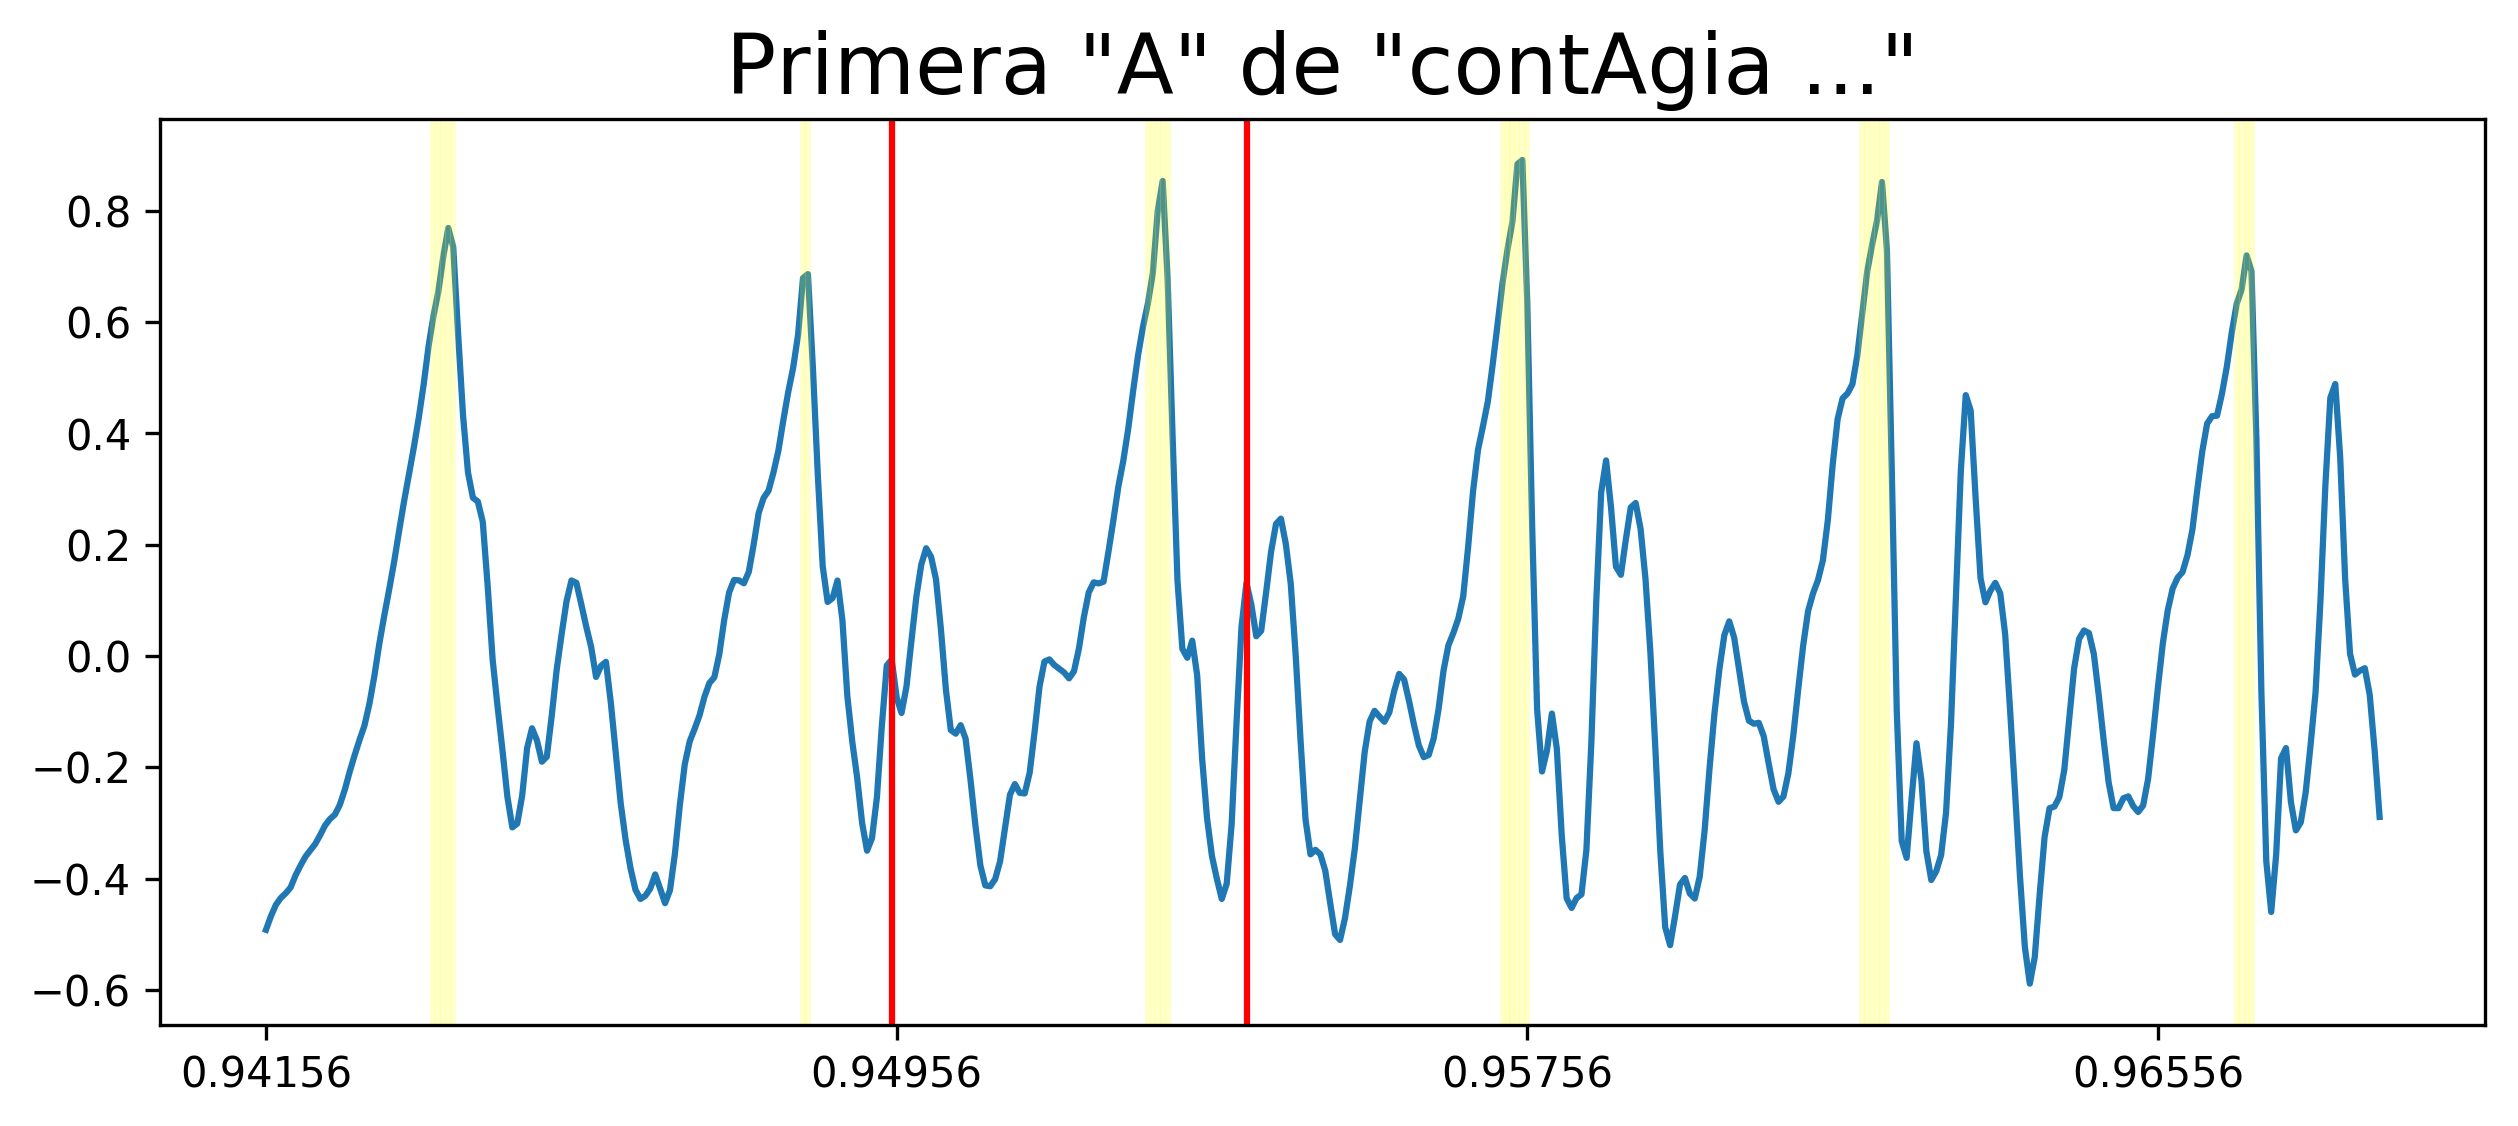

In [171]:
# Tomo a
a1 = Letter.LETTERS_POSITION[4]

def plot_letter(letter: Letter, tittle = None, threeshold = 0.6):
    X_l = X[int(letter.start*FS):int(letter.end*FS)]
    Y_l = Y[int(letter.start*FS):int(letter.end*FS)]

    X_middle = X_l[:len(X_l)//2] # Me quedo con la mitad par ver de cerca
    Y_middle = Y_l[:len(Y_l)//2]

    plt.title(tittle if tittle != None else "Letra {}".format(letter.char), fontsize=20)
    plt.plot(X_middle, Y_middle)
    
    plt.xticks(np.arange(min(X_middle), max(X_middle), 0.008))
    
    # Marco ls picos mas altos
    for x, y in zip(X_middle, Y_middle):
        if y > threeshold:
            x = plt.axvline(x=x, color="yellow", alpha=0.2)
    return X_l, Y_l
    

(X_a1, Y_a1) = plot_letter(a1, r'Primera "A" de "contAgia ..."')

# Busco periodo "a mano"
plt.axvline(x=0.9495, color="red")
plt.axvline(x=0.9495 + 0.00451, color="red")

plt.show()

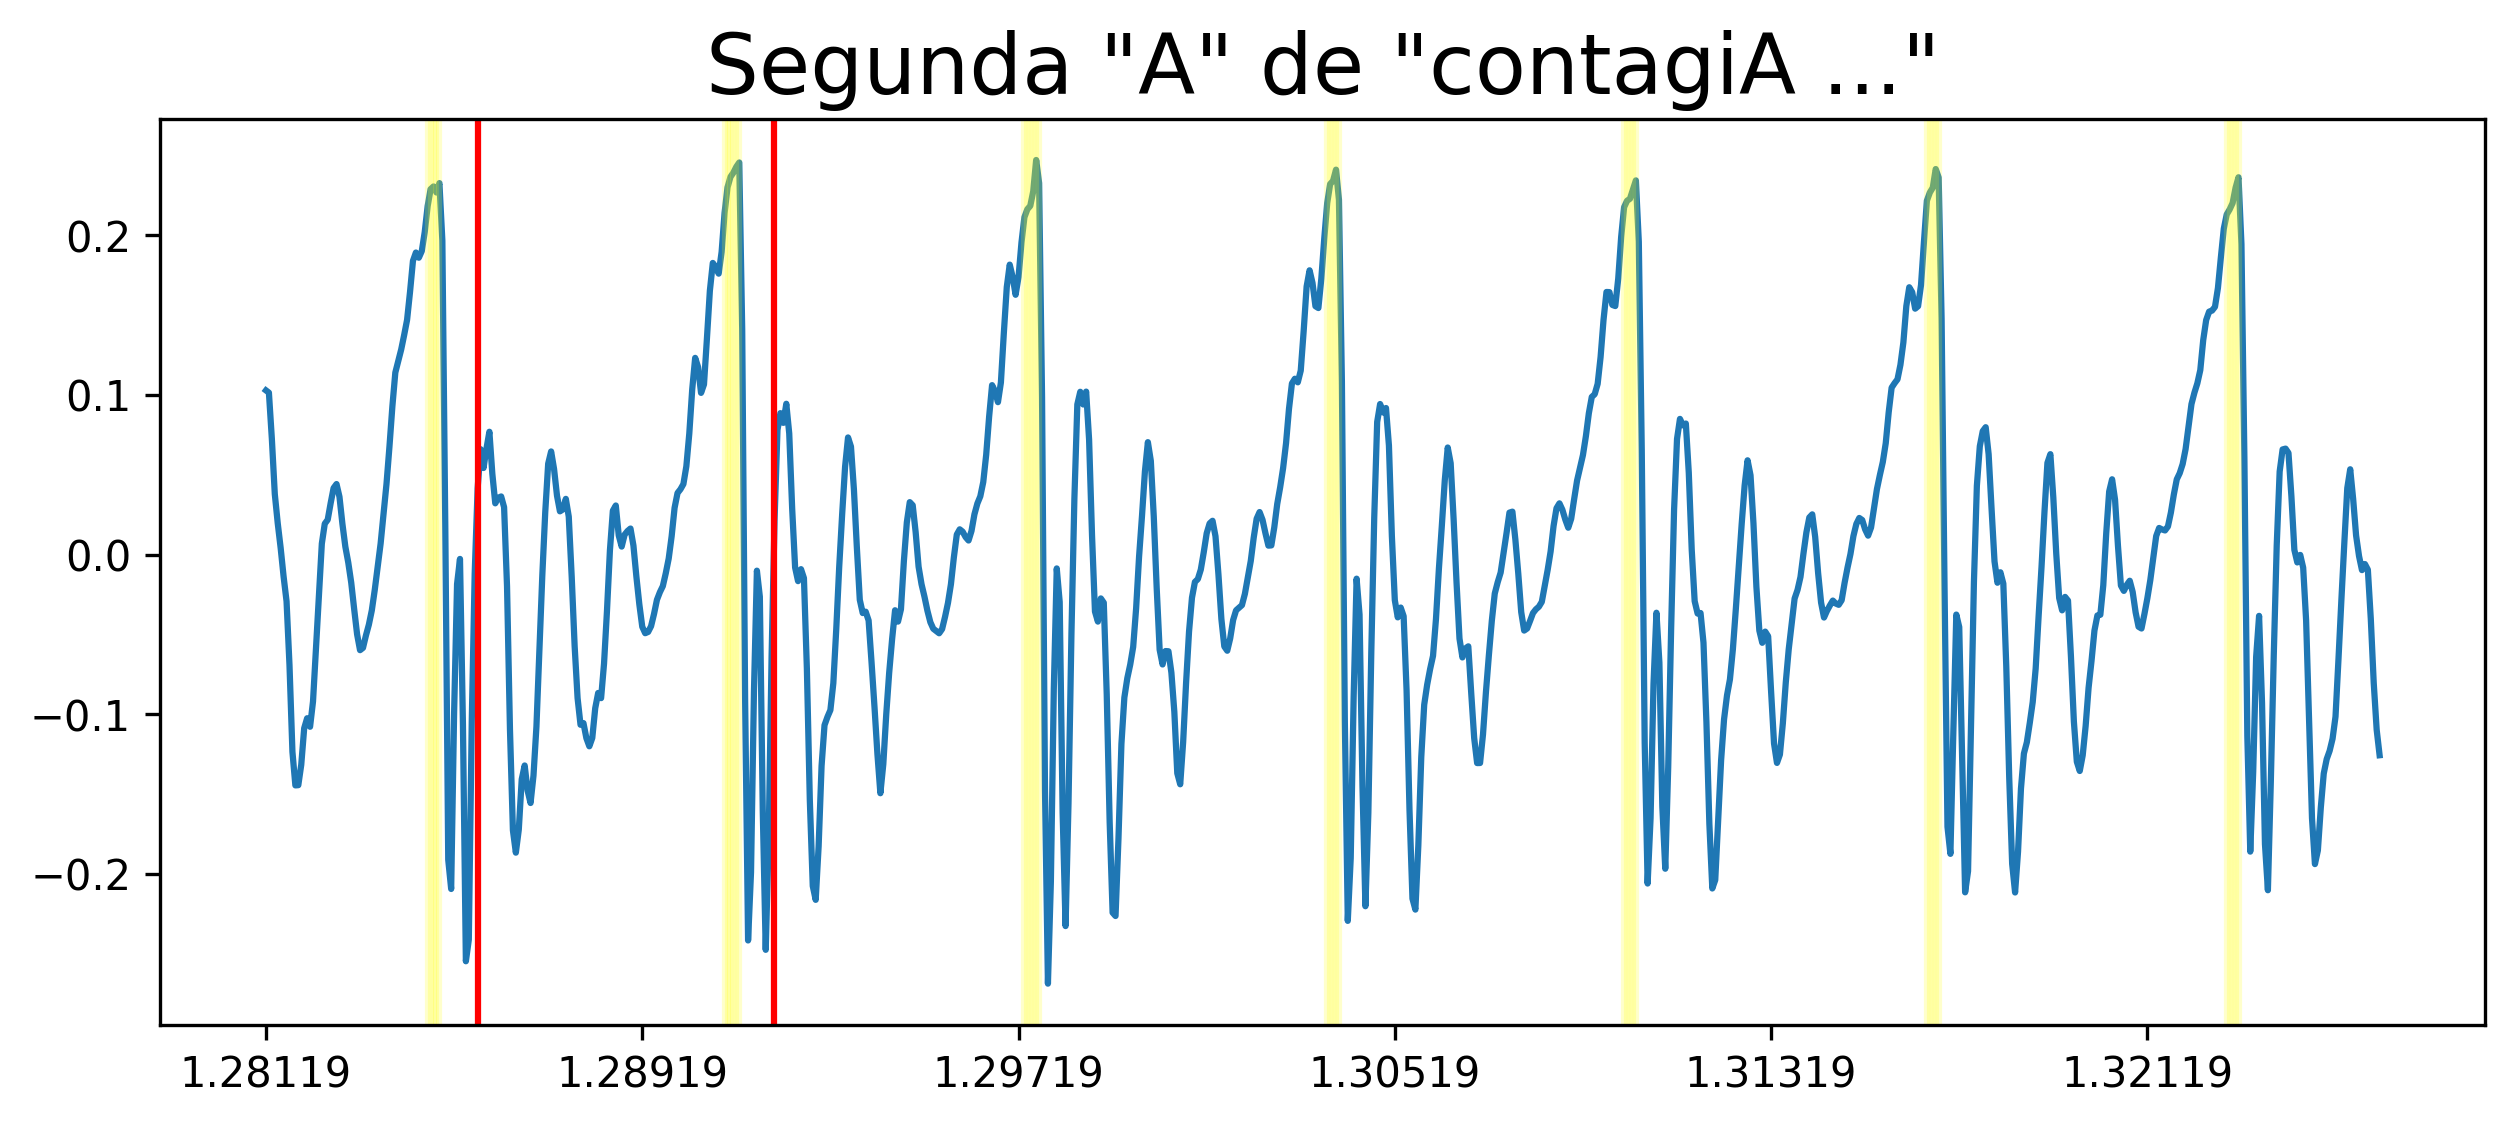

In [172]:
a2 = Letter.LETTERS_POSITION[7]

(X_a2, Y_a2) = plot_letter(a2, r'Segunda "A" de "contagiA ..."',0.21)
# Busco periodo "a mano"
plt.axvline(x=a2.start + 0.0045, color="red")
plt.axvline(x=a2.start + 0.0045 + 0.00628, color="red")

plt.show()

### Busco periodo de primera A Manualmante

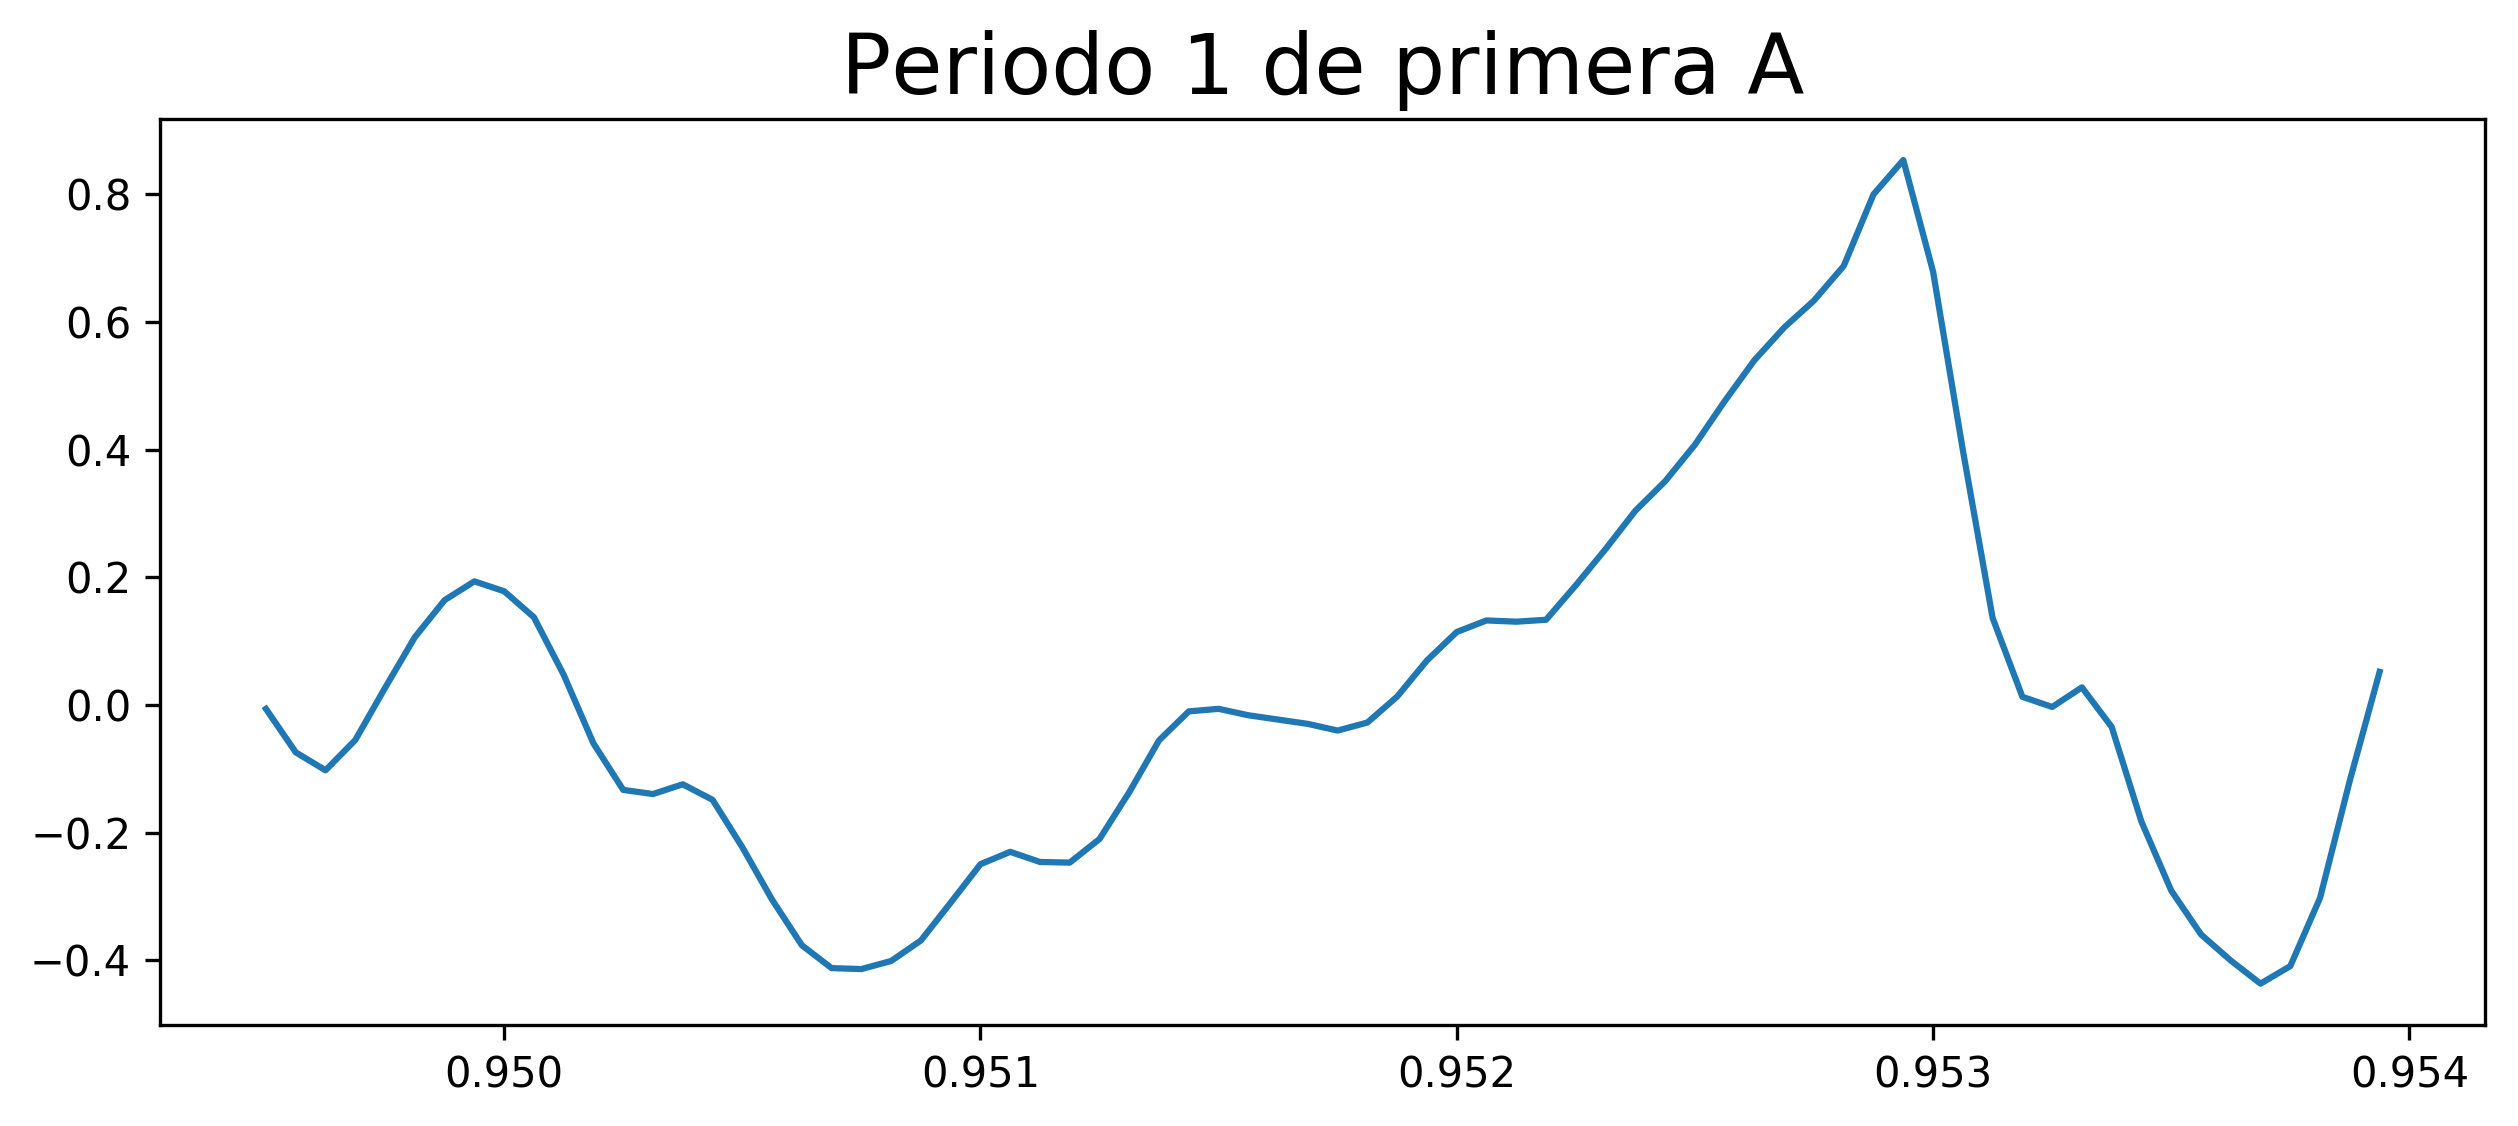

In [178]:
a1_P2_start = 0.9495
a1_T = 0.00453

X_a1_T1 = X[int(a1_P2_start*FS):int((a1_P2_start + a1_T)*FS)]
Y_a1_T1 = Y[int(a1_P2_start*FS):int((a1_P2_start + a1_T)*FS)]

# print("Y[ 0]: {}\nY[-1]: {}\nDiferencia: {}".format(Y_a1_T[0], Y_a1_T[-1], abs(Y_a1_T[0]-Y_a1_T[-1])))

plt.title(r'Periodo 1 de primera A', fontsize=20)
plt.plot(X_a1_T1, Y_a1_T1)

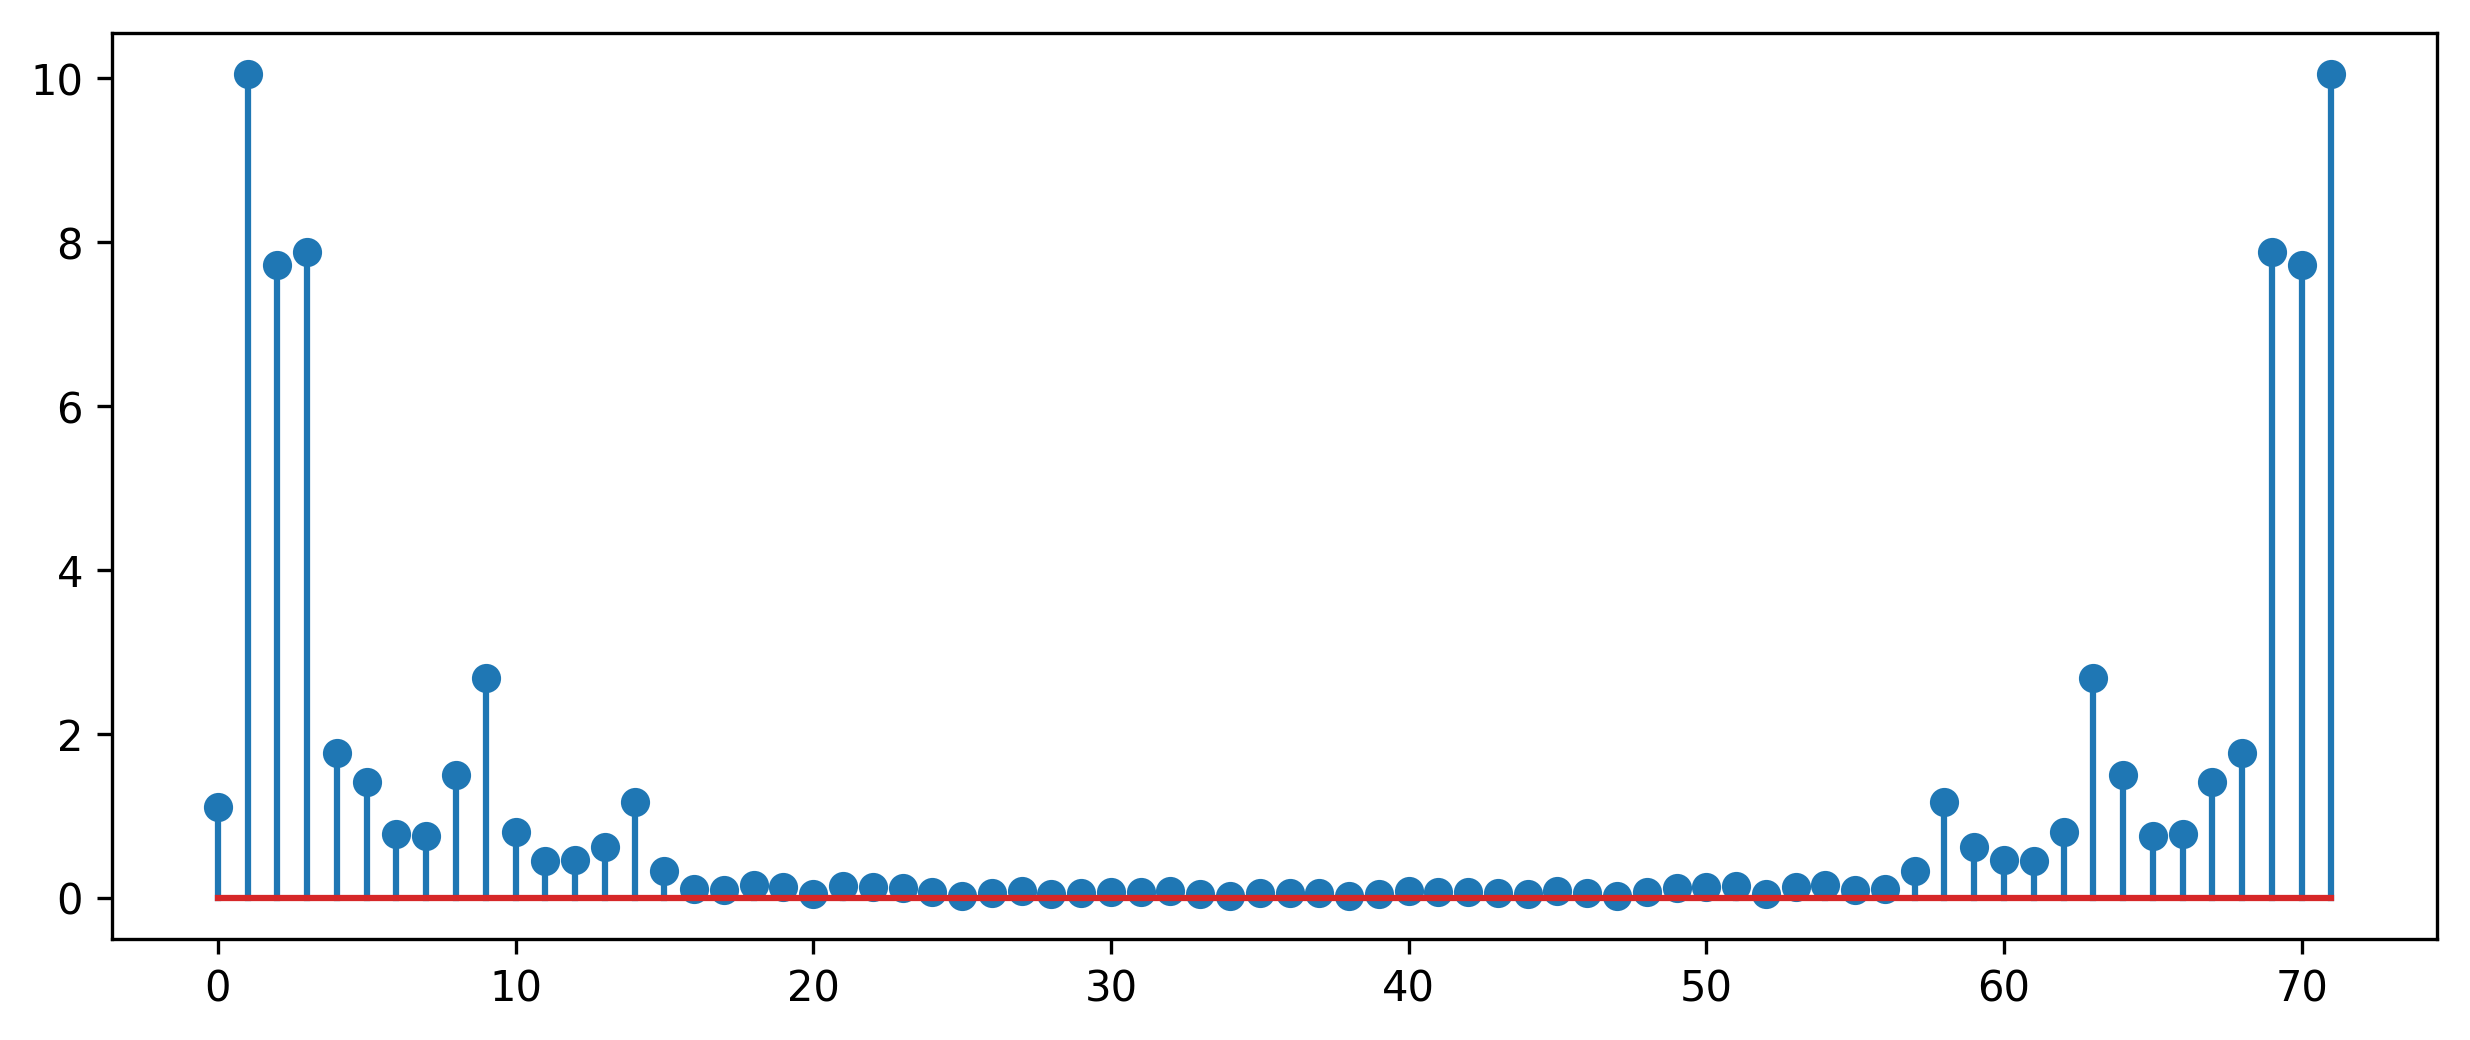

In [179]:
# Calclo DFT (con FFT). Desnormalizo el vector Y
TF_Y_a1_T1 = np.fft.fft(np.array(Y_a1_T1)*max(Y))
plt.stem(np.absolute(TF_Y_a1_T1))
plt.show()

## 3) Reconstruya la señal temporal a partir de los coeficientes calculados. Escuche y compare las distintas reconstrucciones correspondientes a coeficientes de Fourier tomados de distintos períodos. Compárelas también con la señal original. ¿Qué observación se puede hacer sobre la periodicidad de los fonemas vocálicos?



In [180]:
# Reconstruyo la señal usando inversa de fft
Yr_a1_T1 = np.tile(np.real(np.fft.ifft(TF_Y_a1_T1)), 500)
wavfile.write("out/a1-t1.wav", FS, Yr_a1_T)
print("Out: \"{}\" [Duracion: {} seg., FS:{}, Muestras: {}]".format("out/a1.wav", len(Yr_a1_T)/FS, FS, len(Yr_a1_T/FS)))

Out: "out/a1.wav" [Duracion: 2.25 seg., FS:16000, Muestras: 36000]


## 4) Grabe la misma frase del ejercicio 1. Mencionar las diferencias entre ambas señales.

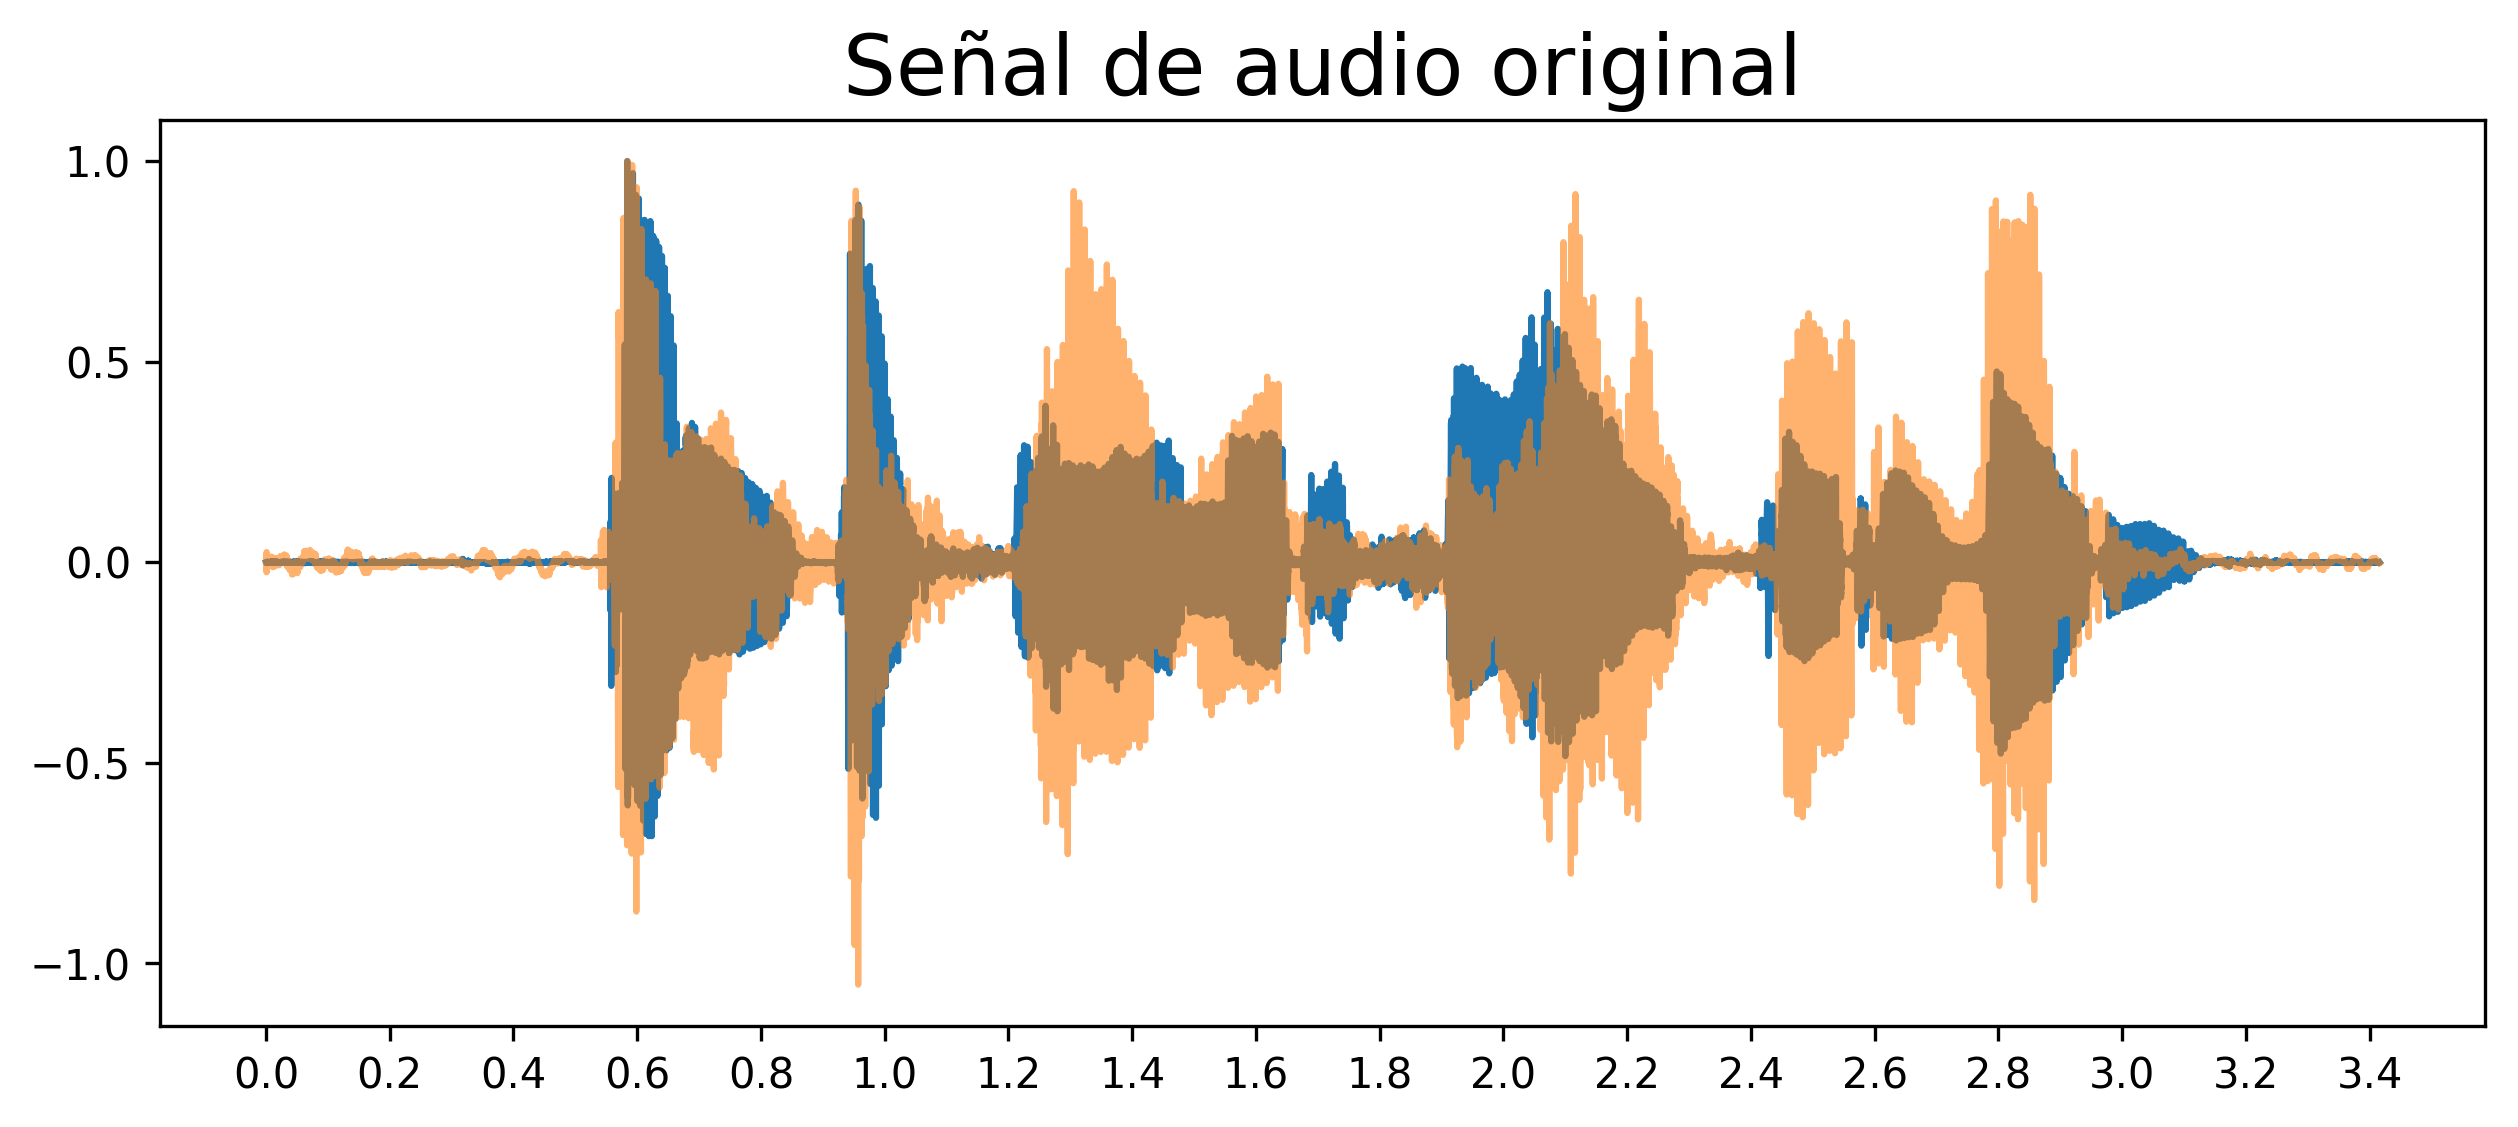

In [177]:
# Plot de original
X = np.arange(0, len(Y))/FS
Y = Y/max(Y) # Y normalizado
plt.title(r'Señal de audio original', fontsize=20)
plt.plot(X, Y) 
plt.xticks(np.arange(min(X), max(X), 0.2))

# Senal grabada
(FS_t, Y_t) = wavfile.read("res/hh15-self.wav")
X_t = np.arange(0, len(Y_t))/FS_t
Y_t = Y_t/max(Y_t) # Y normalizado 
plt.plot(X_t, Y_t, alpha=0.6)
plt.show()

## 5) Grafique los espectrogramas de banda angosta de los segmentos de señal correspondientes a tres vocales presentes en la señal hh15.wav. Compare y analice las diferencias.

``banda angosta`` Un tipo de parametro es el ancho de la ventana (t). Mientras mas ancha, menor resolucion temporal (mas angosta la venta en frecuencia)

Investigar como los otros parametros afectan. **SE TOMA EN EL ORAL**

## 6) Genere diez ciclos del tren de pulsos glóticos según los modelos de Rosenberg. Tomar una frecuencia F0 = 200 Hz, y fases de apertura y cierre de 40% y 16%, respectivamente, de la duración de un pulso. Considerar una amplitud máxima de 1. A los efectos de la simulación, considerar una frecuencia de muestreo de 16 kHz. Estimar su espectro de amplitud y explicar su contenido. Grafique en forma superpuesta el espectro de un pulso y del tren de pulsos. Justifique los resultados observados.

Modelo del pulso blotico (ecuacion 1)

Generar un "pulso"

`t=0:1/16e3:2 --> [0,1/16,2/16,3/16,..2]`


definir: p y x
- x: x = 100000100001 con frecuencia 1/f0

ej. 

x = zeros(1,16e3) --> vector de 16 mil 0

x(1:fs/f0:end) = 1


`pg=conv(p,x)`




## 7) Utilizando las ec. 3 y 4, generar un modelo de tracto vocal para cada uno de los siguientes conjuntos de valores de parámetros, que se corresponde con una vocal emitida por una locutora.

|  | F1  | B1  | F2   | B2  | F3   | B3  | F4   | B4  |
|--|-----|-----|------|-----|------|-----|------|-----|
|**a**| 830 | 110 | 1400 | 160 | 2890 | 210 | 3930 | 230 |
|**e**| 500 | 80  | 2000 | 156 | 3130 | 190 | 4150 | 220 |
|**i**| 330 | 70  | 2765 | 130 | 3740 | 178 | 4336 | 200 |
|**o**| 546 | 97  | 934  | 130 | 2966 | 185 | 3930 | 240 |
|**u**| 382 | 74  | 740  | 150 | 2760 | 210 | 3380 | 180 |

Ver H(w) en el cuaderno. Se genera con ec (3) y (4)

```
freqz -> rta en freq
zplane -> polos y ceros
```

## 8) Utilizando los resultados de los dos último ejercicios, sintetice un segundo de las cinco vocales. Escuche y grafique. Haga un análisis en frecuencia, y en tiempo-frecuencia.

## 9) A partir de las vocales sintetizadas del ejercicio anterior, estime la respuesta en frecuencia correspondiente al tracto vocal y el contorno de la frecuencia fundamental mediante la transformada cepstrum.

## 10) Utilizando nuevamente la transformada cepstrum, estime el contorno de la frecuencia fundamental de la voz en el archivo hh15.wav. Grafique en forma sincrónica con la onda.

## 11) Aplique el método PSOLA para aumentar y disminuir un 10%, 20% y 30% la frecuencia fundamental de la voz en el archivo hh15.wav. Para ello utilice la curva de frecuencia fundamental obtenida en el ejercicio anterior.

## 12) Aplique el método PSOLA para aumentar y disminuir un 10%, 20% y 30% la duración de la voz en el archivo hh15.wav. Para ello utilice la curva de frecuencia fundamental obtenida en el ejercicio anterior.

## 13) Modifique la frecuencia fundamental de las vocales sintetizadas del ejercicio 8 desde 200 a 300 Hz en forma lineal. Escuche la onda resultante, ¿cómo se percibe el cambio en la frecuencia fundamental? Estime el F0 resultante y compárelo con el teórico.

## 14) Repita el ejercicio anterior pero esta vez variando la frecuencia fundamental desde 200 a 100 Hz.

## 15) Aplique un filtro a las vocales sintetizadas del ejercicio 8 para eliminar la frecuencia fundamental. Puede utilizar la herramienta fdatool para diseñar el filtro. Justifique el filtro implementado. Grafique ambas señales, haga un análisis en frecuencia y compare. ¿Perceptualmente se nota alguna diferencia? ¿Porqué?.